In [3]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV

# Resampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [4]:
#Load Dataset
df = pd.read_csv("data_hotel_booking_demand.csv")

df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [5]:
df.tail()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
83572,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1


# Data Cleaning

In [6]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [7]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,351,0.42,162,"[IMN, BOL]"
1,market_segment,object,0,0.00,8,"[Groups, Undefined]"
2,previous_cancellations,int64,0,0.00,15,"[11, 4]"
3,booking_changes,int64,0,0.00,19,"[1, 6]"
4,deposit_type,object,0,0.00,3,"[Refundable, Non Refund]"
5,days_in_waiting_list,int64,0,0.00,115,"[18, 113]"
6,customer_type,object,0,0.00,4,"[Transient-Party, Transient]"
7,reserved_room_type,object,0,0.00,10,"[F, E]"
8,required_car_parking_spaces,int64,0,0.00,5,"[8, 1]"
9,total_of_special_requests,int64,0,0.00,6,"[0, 3]"


*Check Every Columns*

In [8]:
df['country'].unique()

array(['IRL', 'FRA', 'PRT', 'NLD', 'ESP', 'UMI', 'CN', 'LUX', 'BRA',
       'BEL', 'JPN', 'DEU', 'ITA', 'CHE', 'GBR', 'AGO', 'SRB', 'COL',
       'CHN', 'SWE', 'AUT', 'CIV', 'CZE', 'POL', 'USA', 'SGP', 'RUS',
       'ROU', 'DNK', 'IND', 'MAR', 'PHL', 'ARG', 'ISL', 'ZAF', 'LBN',
       'MOZ', 'TUR', 'BGD', 'MEX', 'CAF', 'NOR', 'FIN', 'UKR', 'EGY',
       'ISR', nan, 'KOR', 'AZE', 'HUN', 'AUS', 'EST', 'CHL', 'SVN', 'PRY',
       'ABW', 'ALB', 'LTU', 'ARE', 'HRV', 'SAU', 'NZL', 'LVA', 'ATA',
       'KAZ', 'DZA', 'TWN', 'CRI', 'BIH', 'BGR', 'IRQ', 'OMN', 'VEN',
       'IDN', 'GEO', 'MLT', 'IRN', 'BLR', 'URY', 'LBY', 'TUN', 'BEN',
       'MYS', 'MWI', 'GRC', 'CYP', 'CPV', 'HKG', 'PRI', 'MKD', 'MUS',
       'IMN', 'PAN', 'NGA', 'GLP', 'KHM', 'PER', 'QAT', 'SEN', 'MAC',
       'SVK', 'BHR', 'ECU', 'SYC', 'BOL', 'TJK', 'LCA', 'MDV', 'SYR',
       'ZMB', 'LIE', 'THA', 'MNE', 'BRB', 'CMR', 'JEY', 'GTM', 'LKA',
       'JOR', 'TZA', 'AND', 'ARM', 'GIB', 'VNM', 'PAK', 'JAM', 'DOM',
       'KWT', 'L

In [9]:
df.dropna()['market_segment'].unique()

array(['Offline TA/TO', 'Online TA', 'Direct', 'Groups', 'Corporate',
       'Complementary', 'Aviation', 'Undefined'], dtype=object)

In [10]:
df.dropna()['deposit_type'].unique()

array(['No Deposit', 'Non Refund', 'Refundable'], dtype=object)

In [11]:
df.dropna()['days_in_waiting_list'].unique()

array([  0,   3,  39,  87,  77, 215,  97, 162,  46,  79,   4,  31, 122,
        34,  57, 259,  50,  17,  32,  43,  75,  69,  44,  22, 113,  58,
        38,  65,  48, 236, 176,  25, 108,  91,  19, 160,  68,  28,  63,
        35,  42,  59,  24,   8, 183, 187,  21, 111,  56,  98, 101,  15,
        16,  47,  93,  45,  14,  70,  10,  49, 178,  99,  60,  40,  85,
       223,   6,  33, 391,  20,   1,  41, 147,  55,  80, 379, 150,  61,
       330, 174, 107,  96,  18,  62,  13,  30, 120,  27, 207,  71,   2,
        76, 125,   5,   9, 224,  53,  83,  84,  12,  73, 100,  92,  23,
        11, 105,  26, 193,   7, 165,  74, 121,  36,  64, 185], dtype=int64)

In [12]:
df.dropna()['customer_type'].unique()

array(['Transient-Party', 'Transient', 'Contract', 'Group'], dtype=object)

In [13]:
df.dropna()['reserved_room_type'].unique()

array(['A', 'E', 'D', 'F', 'B', 'G', 'C', 'H', 'L', 'P'], dtype=object)

In [14]:
df.dropna()['booking_changes'].unique()

array([ 0,  1,  2,  5,  3,  4,  6,  7,  9,  8, 17, 10, 13, 12, 14, 21, 16,
       20, 15], dtype=int64)

In [15]:
df.dropna()['is_canceled'].unique()

array([0, 1], dtype=int64)

*Missing Values*

In [16]:
df.isna().sum()/len(df.index)*100

country                        0.419992
market_segment                 0.000000
previous_cancellations         0.000000
booking_changes                0.000000
deposit_type                   0.000000
days_in_waiting_list           0.000000
customer_type                  0.000000
reserved_room_type             0.000000
required_car_parking_spaces    0.000000
total_of_special_requests      0.000000
is_canceled                    0.000000
dtype: float64

# PreProcessing

*Preprocessing Scheme*

- OneHotEncoding: country, market_segment, deposit_type, customer_type, reserved_room_type 
- Manual: previous_cancellations, booking_changes, days_in_waiting_list, required_car_parking_spaces, total_of_special_requests.

In [17]:
mode_onehot_pipe = Pipeline([
    ('encoder', SimpleImputer(strategy = 'most_frequent')),
    ('one hot encoder', OneHotEncoder(handle_unknown = 'ignore'))
])

In [18]:
transformer_scale = ColumnTransformer([
    ('one hot', OneHotEncoder(handle_unknown = 'ignore'), ['country', 'market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']),], remainder = 'passthrough')

In [19]:
df['is_canceled'].value_counts()

0    52795
1    30778
Name: is_canceled, dtype: int64

Dari dataset, ada indikasi imbalance data

In [20]:
df['is_canceled'].value_counts()/df.shape[0]*100

0    63.172316
1    36.827684
Name: is_canceled, dtype: float64

* *0 = cancel*
* *1 = tidak cancel*

        - TN: Ada kosumen yang di prediksi cancel dan kenyataannya cancel
        - TP: Ada kosumen yang di prediksi tidak cancel dan kenyataannya tidak cancel
        - FP: Ada kosumen yang di prediksi cancel dan kenyataannya tidak cancel
        - FN: Ada kosumen yang di prediksi tidak cancel dan kenyataanya cancel

Tindakan:
* FP: konsumen 
* FN: 

- > Yang akan di tekan adalah FP, namun akan mencoba roc_auc_score

*Splitting Data*

In [21]:
X = df.drop('is_canceled', axis = 1)
y = df['is_canceled']

In [22]:
X.shape

(83573, 10)

In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,
                                                   stratify = y,
                                                    test_size = 0.3,
                                                   random_state = 2727)

# Modeling

*Define Model*

In [24]:
logreg = LogisticRegression()
tree = DecisionTreeClassifier(random_state = 2727)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state = 2727)

# Cross Validation

In [25]:
logreg_pipe_scale = Pipeline([
    ('transformer', transformer_scale),
    ('logreg', logreg)
])

tree_pipe_scale = Pipeline([
    ('transformer', transformer_scale),
    ('tree', tree)
])

knn_pipe_scale = Pipeline([
    ('transformer', transformer_scale),
    ('knn', knn)
])

rf_pipe_scale = Pipeline([
    ('transformer', transformer_scale),
    ('rf', rf)
])

In [26]:
def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train_val, y_train_val, cv = skfold, scoring = metric)
    return model_cv

In [27]:
logreg_pipe_scale_cv = model_evaluation(logreg_pipe_scale, 'roc_auc')
tree_pipe_scale_cv = model_evaluation(tree_pipe_scale, 'roc_auc')
knn_pipe_scale_cv = model_evaluation(knn_pipe_scale, 'roc_auc')
rf_pipe_scale_cv = model_evaluation(rf_pipe_scale, 'roc_auc')

In [28]:
for model in [logreg_pipe_scale, tree_pipe_scale, knn_pipe_scale, rf_pipe_scale]:
    model.fit(X_train_val, y_train_val)

In [29]:
score_mean = [logreg_pipe_scale_cv.mean(), tree_pipe_scale_cv.mean(), knn_pipe_scale_cv.mean(),
              rf_pipe_scale_cv.mean()]
score_std = [logreg_pipe_scale_cv.std(), tree_pipe_scale_cv.std(), knn_pipe_scale_cv.std(),
             rf_pipe_scale_cv.std()]
score_roc_auc = [roc_auc_score(y_test, logreg_pipe_scale.predict(X_test)),
            roc_auc_score(y_test, tree_pipe_scale.predict(X_test)), 
            roc_auc_score(y_test, knn_pipe_scale.predict(X_test)), 
            roc_auc_score(y_test, rf_pipe_scale.predict(X_test))]
method_name = ['Logistic Regression', 'Decision Tree Classifier',
              'KNN Classifier', 'Random Forest Classifier']
cv_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'roc auc score': score_roc_auc
})
cv_summary

,method,mean score,std score,roc auc score
0,Logistic Regression,0.863770,0.003051,0.739714
1,Decision Tree Classifier,0.877183,0.003211,0.785551
2,KNN Classifier,0.847389,0.006549,0.761929
3,Random Forest Classifier,0.887720,0.003500,0.786337


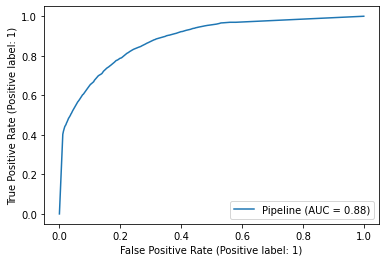

In [30]:
plot_roc_curve(tree_pipe_scale, X_test, y_test)

# Handling Imbalance

### UnderSampling

**RandomUnderSampler Model**

In [31]:
rus = RandomUnderSampler(random_state = 2727)
X_under, y_under = rus.fit_resample(X_train_val, y_train_val) 

In [32]:
logreg_pipe_scale_under = Pipeline([
    ('transformer', transformer_scale),
    ('rus', rus),
    ('logreg', logreg)
])

tree_pipe_scale_under = Pipeline([
    ('transformer', transformer_scale),
    ('rus', rus),
    ('tree', tree)
])

knn_pipe_scale_under = Pipeline([
    ('transformer', transformer_scale),
    ('rus', rus),
    ('knn', knn)
])

rf_pipe_scale_under = Pipeline([
    ('transformer', transformer_scale),
    ('rus', rus),
    ('rf', rf)
])

In [33]:
def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_under, y_under, cv = skfold, scoring = metric)
    return model_cv  

In [34]:
logreg_scale_under_cv = model_evaluation(logreg_pipe_scale_under, 'roc_auc') 
tree_scale_under_cv = model_evaluation(tree_pipe_scale_under, 'roc_auc')
knn_pipe_under_cv = model_evaluation(knn_pipe_scale_under, 'roc_auc')
rf_pipe_under_cv = model_evaluation(rf_pipe_scale_under, 'roc_auc')

*Fitting Data*

In [35]:
for model in [logreg_pipe_scale_under, tree_pipe_scale_under, knn_pipe_scale_under, rf_pipe_scale_under]:
    model.fit(X_train_val, y_train_val)

*Summary*

In [36]:
score_mean = [logreg_scale_under_cv.mean(), tree_scale_under_cv.mean(), knn_pipe_under_cv.mean(),
              rf_pipe_under_cv.mean()]
score_std = [logreg_scale_under_cv.std(), tree_scale_under_cv.std(), knn_pipe_under_cv.std(),
             rf_pipe_under_cv.std()]
score_roc_auc = [roc_auc_score(y_test, logreg_pipe_scale_under.predict(X_test)),
            roc_auc_score(y_test, tree_pipe_scale_under.predict(X_test)), 
            roc_auc_score(y_test, knn_pipe_scale_under.predict(X_test)), 
            roc_auc_score(y_test, rf_pipe_scale_under.predict(X_test))]
method_name = ['Logistic Regression UnderSampling', 'Decision Tree Classifier UnderSampling',
              'KNN Classifier UnderSampling', 'Random Forest Classifier UnderSampling']
under_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'roc auc score': score_roc_auc
})
under_summary

,method,mean score,std score,roc auc score
0,Logistic Regression UnderSampling,0.863540,0.001330,0.773935
1,Decision Tree Classifier UnderSampling,0.872681,0.003053,0.794596
2,KNN Classifier UnderSampling,0.844255,0.005478,0.768074
3,Random Forest Classifier UnderSampling,0.886038,0.002125,0.796331


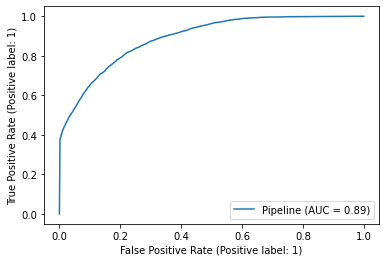

In [37]:
plot_roc_curve(rf_pipe_scale_under, X_test, y_test)

**NearMiss Model**
- NearMiss adds some heuristic rules to select samples based on nearest neighbors algorithm.

In [38]:
nm = NearMiss(version = 1)

In [39]:
logreg_pipe_scale_nm = Pipeline([
    ('transformer', transformer_scale),
    ('nm', nm),
    ('logreg', logreg)
])

tree_pipe_scale_nm = Pipeline([
    ('transformer', transformer_scale),
    ('nm', nm),
    ('tree', tree)
])

knn_pipe_scale_nm = Pipeline([
    ('transformer', transformer_scale),
    ('nm', nm),
    ('knn', knn)
])

rf_pipe_scale_nm = Pipeline([
    ('transformer', transformer_scale),
    ('nm', nm),
    ('rf', rf)
])

In [40]:
def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train_val, y_train_val, cv = skfold, scoring = metric)
    return model_cv

In [41]:
logreg_scale_nm_cv = model_evaluation(logreg_pipe_scale_nm, 'roc_auc') 
tree_scale_nm_cv = model_evaluation(tree_pipe_scale_nm, 'roc_auc')
knn_pipe_nm_cv = model_evaluation(knn_pipe_scale_nm, 'roc_auc')
rf_pipe_nm_cv = model_evaluation(rf_pipe_scale_nm, 'roc_auc')

*Fitting Data*

In [42]:
for model in [logreg_pipe_scale_nm, tree_pipe_scale_nm, knn_pipe_scale_nm, rf_pipe_scale_nm]:
    model.fit(X_train_val, y_train_val)

*Summary*

In [43]:
score_mean = [logreg_scale_nm_cv.mean(), tree_scale_nm_cv.mean(), knn_pipe_nm_cv.mean(),
              rf_pipe_nm_cv.mean()]
score_std = [logreg_scale_nm_cv.std(), tree_scale_nm_cv.std(), knn_pipe_nm_cv.std(),
             rf_pipe_nm_cv.std()]
score_roc_auc = [roc_auc_score(y_test, logreg_pipe_scale_nm.predict(X_test)),
            roc_auc_score(y_test, tree_pipe_scale_nm.predict(X_test)), 
            roc_auc_score(y_test, knn_pipe_scale_nm.predict(X_test)), 
            roc_auc_score(y_test, rf_pipe_scale_nm.predict(X_test))]
method_name = ['Logistic Regression NearMiss', 'Decision Tree Classifier NearMiss',
              'KNN Classifier NearMiss', 'Random Forest Classifier NearMiss']
nm_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'roc auc score': score_roc_auc
})
nm_summary

,method,mean score,std score,roc auc score
0,Logistic Regression NearMiss,0.836733,0.005717,0.732235
1,Decision Tree Classifier NearMiss,0.843620,0.010298,0.770394
2,KNN Classifier NearMiss,0.788325,0.009000,0.718994
3,Random Forest Classifier NearMiss,0.847979,0.004742,0.769796


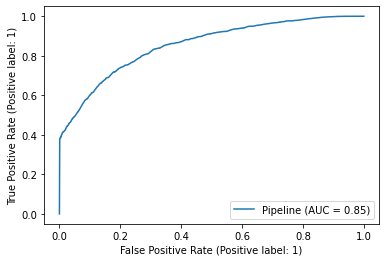

In [44]:
plot_roc_curve(rf_pipe_scale_nm, X_test, y_test)

### OverSampling

**RandomOverSampler Model**

In [45]:
ros = RandomOverSampler(random_state = 2727)
X_over, y_over = ros.fit_resample(X_train_val, y_train_val)

In [46]:
logreg_pipe_scale_over = Pipeline([
    ('transformer', transformer_scale),
    ('ros', ros), 
    ('logreg', logreg)
])

tree_pipe_scale_over = Pipeline([
    ('transformer', transformer_scale),
    ('ros', ros), 
    ('tree', tree)
])

knn_pipe_scale_over = Pipeline([
    ('transformer', transformer_scale),
    ('ros', ros), 
    ('knn', knn)
])

rf_pipe_scale_over = Pipeline([
    ('transformer', transformer_scale),
    ('ros', ros),
    ('rf', rf)
])

In [47]:
def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_over, y_over, cv = skfold, scoring = metric)
    return model_cv

In [48]:
logreg_scale_over_cv = model_evaluation(logreg_pipe_scale_over, 'roc_auc') 
tree_scale_over_cv = model_evaluation(tree_pipe_scale_over, 'roc_auc')
knn_pipe_over_cv = model_evaluation(knn_pipe_scale_over, 'roc_auc')
rf_pipe_over_cv = model_evaluation(rf_pipe_scale_over, 'roc_auc')

*Fitting Data*

In [49]:
for model in [logreg_pipe_scale_over, tree_pipe_scale_over, knn_pipe_scale_over, rf_pipe_scale_over]:
    model.fit(X_train_val, y_train_val)

In [50]:
score_mean = [logreg_scale_over_cv.mean(), tree_scale_over_cv.mean(), knn_pipe_over_cv.mean(),
              rf_pipe_over_cv.mean()]
score_std = [logreg_scale_over_cv.std(), tree_scale_over_cv.std(), knn_pipe_over_cv.std(),
             rf_pipe_over_cv.std()]
score_roc_auc = [roc_auc_score(y_test, logreg_pipe_scale_over.predict(X_test)),
            roc_auc_score(y_test, tree_pipe_scale_over.predict(X_test)), 
            roc_auc_score(y_test, knn_pipe_scale_over.predict(X_test)), 
            roc_auc_score(y_test, rf_pipe_scale_over.predict(X_test))]
method_name = ['Logistic Regression OverSampling', 'Decision Tree Classifier OverSampling',
              'KNN Classifier OverSampling', 'Random Forest Classifier OverSampling']
over_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'roc auc score': score_roc_auc
})
over_summary

,method,mean score,std score,roc auc score
0,Logistic Regression OverSampling,0.864713,0.002512,0.777938
1,Decision Tree Classifier OverSampling,0.895014,0.007252,0.795857
2,KNN Classifier OverSampling,0.854122,0.006037,0.771894
3,Random Forest Classifier OverSampling,0.901135,0.006398,0.796562


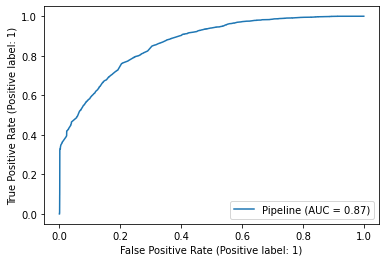

In [51]:
plot_roc_curve(logreg_pipe_scale_over, X_test, y_test)

**SMOTE**

In [52]:
smote = SMOTE(random_state = 2727)

In [53]:
logreg_pipe_scale_smote = Pipeline([
    ('transformer', transformer_scale),
    ('smote', smote),
    ('logreg', logreg)
])

tree_pipe_scale_smote = Pipeline([
    ('transformer', transformer_scale),
    ('smote', smote),
    ('tree', tree)
])

knn_pipe_scale_smote = Pipeline([
    ('transformer', transformer_scale),
    ('smote', smote),
    ('knn', knn)
])

rf_pipe_scale_smote = Pipeline([
    ('transformer', transformer_scale),
    ('smote', smote),
    ('rf', rf)
])

In [54]:
def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train_val, y_train_val, cv = skfold, scoring = metric)
    return model_cv

In [55]:
logreg_scale_smote_cv = model_evaluation(logreg_pipe_scale_smote, 'roc_auc') 
tree_scale_smote_cv = model_evaluation(tree_pipe_scale_smote, 'roc_auc')
knn_pipe_smote_cv = model_evaluation(knn_pipe_scale_smote, 'roc_auc')
rf_pipe_smote_cv = model_evaluation(rf_pipe_scale_smote, 'roc_auc')

*Fitting Data*

In [56]:
for model in [logreg_pipe_scale_smote, tree_pipe_scale_smote, knn_pipe_scale_smote, rf_pipe_scale_smote]:
    model.fit(X_train_val, y_train_val)

*Summary*

In [57]:
score_mean = [logreg_scale_smote_cv.mean(), tree_scale_smote_cv.mean(), knn_pipe_smote_cv.mean(),
              rf_pipe_smote_cv.mean()]
score_std = [logreg_scale_smote_cv.std(), tree_scale_smote_cv.std(), knn_pipe_smote_cv.std(),
             rf_pipe_smote_cv.std()]
score_roc_auc = [roc_auc_score(y_test, logreg_pipe_scale_smote.predict(X_test)),
            roc_auc_score(y_test, tree_pipe_scale_smote.predict(X_test)), 
            roc_auc_score(y_test, knn_pipe_scale_smote.predict(X_test)), 
            roc_auc_score(y_test, rf_pipe_scale_smote.predict(X_test))]
method_name = ['Logistic Regression SMOTE', 'Decision Tree Classifier SMOTE',
              'KNN Classifier SMOTE', 'Random Forest Classifier SMOTE']
smote_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'roc auc score': score_roc_auc
})
smote_summary

,method,mean score,std score,roc auc score
0,Logistic Regression SMOTE,0.864258,0.003300,0.775111
1,Decision Tree Classifier SMOTE,0.876950,0.002916,0.796288
2,KNN Classifier SMOTE,0.843936,0.008681,0.770101
3,Random Forest Classifier SMOTE,0.887571,0.003439,0.797091


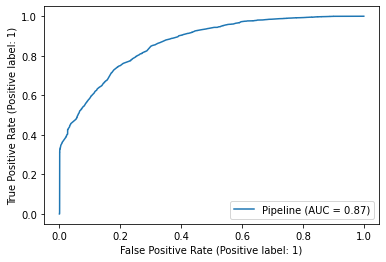

In [58]:
plot_roc_curve(logreg_pipe_scale_smote, X_test, y_test)

# HyperParam Tuning

In [59]:
estimator = Pipeline([
    ('transformer', transformer_scale),
    ('rus', rus),
    ('model', rf)
])

hyperparam_space = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [2, 3, 5, 7, 10, 15, 20],
    'model__min_samples_leaf': [3, 7, 9, 13, 15, 21],
    'model__max_features': [20, 30, 40, 50]
}

random = RandomizedSearchCV(
                estimator,
                param_distributions = hyperparam_space,
                cv = StratifiedKFold(n_splits = 5),
                scoring = 'roc_auc',
                n_iter = 10,
                n_jobs = -1)

In [60]:
random.fit(X_train_val, y_train_val)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one '
                                                                               'hot',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['country',
                                                                                'market_segment',
                                                                                'deposit_type',
                                                                                'customer_type',
                                                                                'reserved_ro

In [61]:
print('best score', random.best_score_)
print('best param', random.best_params_)

best score 0.8914417751339201
best param {'model__n_estimators': 50, 'model__min_samples_leaf': 7, 'model__max_features': 30, 'model__max_depth': 20, 'model__criterion': 'entropy'}


Comparing to all Handling Methods that I've been running, the best model is:
- RandomForestClassifier with UnderSampling
- Best Score: 0.88
- Best Estimator: 200
- Best Min Samples Leaf: 9
- Best Max Features: 20
- Best Max Depth: 15
- Best Criterion: entropy

# Before VS After Tuning

In [62]:
estimator.fit(X_train_val, y_train_val)
y_pred_estimator = estimator.predict(X_test)
roc_auc_estimator = roc_auc_score(y_test, y_pred_estimator)

random.best_estimator_.fit(X_train_val, y_train_val)
y_pred_random = random.best_estimator_.predict(X_test)
roc_auc_best_estimator = roc_auc_score(y_test, y_pred_random)

In [63]:
score_list = [roc_auc_estimator, roc_auc_best_estimator]
method_name = ['Random Forest Classifier UnderSampling Before', 'Random Forest Classifier UnderSampling After']
best_summary = pd.DataFrame({
    'method': method_name,
    'score': score_list
})
best_summary

,method,score
0,Random Forest Classifier UnderSampling Before,0.796331
1,Random Forest Classifier UnderSampling After,0.795622


# Using ML

In [65]:
import pickle

In [67]:
file_name = "data_hotel_booking_demand.csv"
pickle.dump(estimator, open(file_name, 'wb'))

In [68]:
loaded_model = pickle.load(open(file_name, 'rb'))

In [69]:
loaded_model.predict(X_test)

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [70]:
hotel_pred = pd.DataFrame({
    'country': ['PRT'],
    'market_segment': ['Online TA'],
    'previous_cancellations': ['0'],
    'booking_changes': ['0'],
    'deposit_type': ['No Deposit'],
    'days_in_waiting_list': ['0'],
    'customer_type': ['Contract'],
    'reserved_room_type': ['A'],
    'required_car_parking_spaces': ['0'],
    'total_of_special_requests': ['0'],
})

In [71]:
loaded_model.predict(hotel_pred)

array([1], dtype=int64)

In [72]:
loaded_model.predict_proba(hotel_pred)

array([[0.27905876, 0.72094124]])